# 4C. Forecasting 2045 Data Preprocessing

This notebook details the steps to prepare the data for future scenario crash risk assessments. 

<a id='sections'></a>
**Sections**

- [**4C. Forecasting 2045 Data Preprocessing**](#forecasting-2045-data-preprocessing)
    - [4C.1 Import libraries, modules and data](#import-libraries-modules-and-data)
    - [4C.2 Prepare 2045 PCD roadway network](#prepare-2045-PCD-roadway-network)
    - [4C.3 Update all the features in 2045 except Pop_den](#update-all-the-features-in-2045-except-Pop_den)
    - [4C.4 Update Pop_den for roadsegment](#update-Pop_den-for-roadsegment)
    - [4C.5 Rearrange columns](#rearrange-columns)
    - [4C.6 Save 2045 data](#save-2045-data)
    - [4C.7 Mapping](#mapping)

# 4C.1 Import libraries, modules and data
<a id='import-libraries-modules-and-data'></a>
[[back to top](#sections)]

In [1]:
# import libraries
import pickle
import json
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import collections
import importlib
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [3]:
import sys; sys.path.insert(0, '..')
from src.models import *
from src.data_preprocessing_2045 import *

Using TensorFlow backend.


In [4]:
base_gis_dir  = "G:/CUUATS/Safety Forecasting Tool/"
base_file_dir = "L:/Safety Forecasting Tool/"
base_tool_dir = "L:/Safety_Crash Data Analysis/"

# 4C.2 Prepare 2045 PCD roadway network
<a id='prepare-2045-PCD-roadway-network'></a>
[[back to top](#sections)]

In [5]:
with open(base_file_dir+'data/interim/roadway/data_source/streets.pkl', 'rb') as f:
    streets = pickle.load(f)

In [6]:
streets.columns

Index(['segment_id', 'geometry', 'bicycle_approach_alignment',
       'bicycle_buffer_width', 'bicycle_facility_width',
       'crossing_functional_classification', 'intersection_control_type',
       'lane_configuration', 'overall_landuse', 'railroad_crossing_type',
       'sidewalk_buffer_type', 'sidewalk_buffer_width', 'bicycle_buffer_type',
       'bicycle_path_category', 'bicycle_path_type', 'bus_trips_total',
       'crossing_aadt', 'crossing_speed', 'heavy_vehicle_count',
       'intersection_median_refuge', 'max_lanes_crossed', 'pavement_condition',
       'right_turn_length', 'road_sign_type', 'sidewalk_condition_score',
       'sidewalk_width', 'volume_capacity', 'geom', 'name', 'one_way',
       'posted_speed', 'overlap', 'start_intersection_id',
       'end_intersection_id', 'total_lanes', 'marked_center_line',
       'lanes_per_direction', 'parking_lane_width', 'idot_inventory',
       'idot_begin_station', 'idot_end_station', 'in_urbanized_area',
       'functional_classi

In [7]:
def geo_segmentid(streets):
    """
    This function project PCD roadway (sub)segments to epsg:3435
    """
    SegmentID=streets[['segment_id','st_astext','overlap']]
    SegmentID.loc[:,'geom'] = SegmentID.loc[:,'st_astext'].apply(wkt.loads)
    geo_SegmentID = gpd.GeoDataFrame(
        SegmentID,
        geometry=SegmentID.geom,
        crs = {'init': 'epsg:3435'})

    return geo_SegmentID

# Project PCD roadway segments to epsg:3435
geo_SegmentID = geo_segmentid(streets)

In [8]:
# Check the number of segments
len(np.unique(geo_SegmentID.segment_id))

14941

In [9]:
streets_2045 = gpd.read_file(base_file_dir+'data/raw/roadway/'+'lts_score.gpkg',layer='result')
streets_2045 = streets_2045.to_crs("EPSG:3435")

In [10]:
streets_2045.head()

segment_id             name cross_name_start cross_name_end  \
0           1     Glenshire Dr       Danbury Dr    W Kirby Ave   
1           2     Plum Tree Dr    Apple Tree Dr           None   
2           3  Fountain Valley             None           None   
3           4            US 45             None           None   
4           5             None            3500N           None   

   start_intersection_id  end_intersection_id   aadt  bicycle_facility_width  \
0                   2930                 2950  375.0                     NaN   
1                    249                  250  676.0                     NaN   
2                   6727                 6726    NaN                     NaN   
3                   6955                 6957    NaN                     NaN   
4                   9180                 9177    NaN                     NaN   

  bicycle_path_category  bicycle_buffer_width  ... sidewalk_condition_score  \
0                  None                   NaN  ...                     80.0   
1                  None                   NaN  ...                      NaN   
2                  None                   NaN  ...                      NaN   
3                  None                   NaN  ...                      NaN   
4                  None                   NaN  ...                      NaN   

  sidewalk_width sidewalk_buffer_type  total_lanes  volume_capacity  \
0           48.0           Landscaped          2.0              NaN   
1            NaN                 None          2.0              NaN   
2            NaN                 None          NaN              NaN   
3            NaN                 None          NaN              NaN   
4            NaN                 None          NaN              NaN   

    overall_landuse  blts_score alts_score  plts_score  \
0      Agricultural           2          1           3   
1  Heavy Industrial           1          1           4   
2      Agricultural           1          1           4   
3              None           4          1           4   
4      Agricultural           3          1           4   

                                            geometry  
0  LINESTRING (990250.010 1250037.162, 990247.945...  
1  LINESTRING (1018513.362 1265282.367, 1018626.8...  
2  LINESTRING (1029766.300 1315986.300, 1029858.2...  
3  LINESTRING (1004692.299 1213384.699, 1004753.5...  
4  LINESTRING (1064665.653 1354535.077, 1064656.7...  

[5 rows x 41 columns]

In [11]:
streets_2045.describe()

segment_id  start_intersection_id  end_intersection_id          aadt  \
count  14941.000000           14941.000000         14941.000000  12816.000000   
mean    8367.877920            5224.627535          5260.703768   1927.745318   
std     4652.176806            3237.119583          3245.499146   4356.812089   
min        1.000000               1.000000             1.000000     10.000000   
25%     4304.000000            2419.000000          2482.000000    500.000000   
50%     8622.000000            5042.000000          5069.000000    676.000000   
75%    12357.000000            7877.000000          7910.000000    850.000000   
max    16092.000000           11741.000000         11741.000000  63000.000000   

       bicycle_facility_width  bicycle_buffer_width  bus_trips_total  \
count             1859.000000           1428.000000      1299.000000   
mean                79.653577             29.684174      4287.034642   
std                 28.807674             60.058723      5995.796984   
min                  0.000000              0.000000        13.000000   
25%                 67.000000              0.000000      1384.000000   
50%                 96.000000              0.000000      2505.000000   
75%                 96.000000             30.000000      4702.000000   
max                202.000000            516.000000     55390.000000   

       crossing_aadt  crossing_speed  heavy_vehicle_count  ...  posted_speed  \
count   13042.000000    12564.000000           640.000000  ...  13158.000000   
mean     2039.284542       34.604027          1863.306250  ...     33.949536   
std      4233.048780       12.555711          2637.352475  ...     12.351089   
min        10.000000        0.000000           100.000000  ...      0.000000   
25%       676.000000       30.000000           332.500000  ...     30.000000   
50%       676.000000       30.000000           600.000000  ...     30.000000   
75%      1150.000000       40.000000          1075.000000  ...     35.000000   
max     63000.000000       70.000000          9275.000000  ...     70.000000   

       right_turn_length  sidewalk_buffer_width  sidewalk_condition_score  \
count         145.000000            6041.000000               6379.000000   
mean          141.317241             113.248469                 76.620473   
std            77.830184              51.567441                 21.551815   
min            22.000000               0.000000                 20.000000   
25%            84.000000             108.000000                 60.000000   
50%           121.000000             132.000000                 80.000000   
75%           184.000000             132.000000                100.000000   
max           415.000000             608.000000                100.000000   

       sidewalk_width  total_lanes  volume_capacity    blts_score  \
count     6381.000000  7659.000000      3268.000000  14941.000000   
mean        57.750509     2.164904         0.309119      1.702162   
std         19.443088     0.585443         0.246522      0.982532   
min          4.000000     1.000000         0.000000      1.000000   
25%         46.000000     2.000000         0.089725      1.000000   
50%         48.000000     2.000000         0.275185      1.000000   
75%         60.000000     2.000000         0.475357      3.000000   
max        223.000000     7.000000         1.340190      4.000000   

         alts_score    plts_score  
count  14941.000000  14941.000000  
mean       1.414564      3.711733  
std        0.669582      0.548665  
min        0.000000      1.000000  
25%        1.000000      4.000000  
50%        1.000000      4.000000  
75%        2.000000      4.000000  
max        4.000000      4.000000  

[8 rows x 23 columns]

In [12]:
streets_2045.columns

Index(['segment_id', 'name', 'cross_name_start', 'cross_name_end',
       'start_intersection_id', 'end_intersection_id', 'aadt',
       'bicycle_facility_width', 'bicycle_path_category',
       'bicycle_buffer_width', 'bicycle_buffer_type', 'bicycle_path_type',
       'bicycle_approach_alignment', 'bus_trips_total', 'crossing_aadt',
       'crossing_functional_classification', 'crossing_speed',
       'functional_classification', 'heavy_vehicle_count',
       'intersection_control_type', 'intersection_median_refuge',
       'lane_configuration', 'lanes_per_direction', 'max_lanes_crossed',
       'parking_lane_width', 'pavement_condition', 'posted_speed',
       'railroad_crossing_type', 'right_turn_length', 'road_sign_type',
       'sidewalk_buffer_width', 'sidewalk_condition_score', 'sidewalk_width',
       'sidewalk_buffer_type', 'total_lanes', 'volume_capacity',
       'overall_landuse', 'blts_score', 'alts_score', 'plts_score',
       'geometry'],
      dtype='object')

In [13]:
# join streets_2045 to streets to match the segment_id
street_2045_seg = pd.merge(geo_SegmentID,streets_2045,how='left',left_on = ['segment_id'], right_on = ['segment_id'])
street_2045_seg = street_2045_seg.drop(['geometry_x','geometry_y'],axis=1)
street_2045_seg['Year'] = 2045
street_2045_seg = street_2045_seg[['segment_id','overlap','bicycle_facility_width',
       'bicycle_path_category', 'bicycle_buffer_width', 'bicycle_buffer_type',
       'bicycle_path_type', 'bicycle_approach_alignment', 'bus_trips_total',
       'crossing_aadt', 'crossing_functional_classification', 'crossing_speed',
       'functional_classification','intersection_control_type',
       'lane_configuration','max_lanes_crossed','parking_lane_width', 'posted_speed', 
       'pavement_condition','railroad_crossing_type', 'right_turn_length', 'road_sign_type',
       'sidewalk_buffer_width', 'sidewalk_condition_score', 'sidewalk_width',
       'sidewalk_buffer_type', 'total_lanes', 'volume_capacity',
       'overall_landuse','aadt', 'heavy_vehicle_count','Year']]

Segments in the street_2045_seg database needs to be filtered with overlap= 'P' to remove duplicated geometry records. Prior to this step, three segments in the database needs to be updated with overlap='S' as they have been miscoded.
The segment_id of these three segments are 1058, 6078, and 6985.

In [14]:
street_2045_seg.shape

(14941, 32)

In [15]:
street_2045_seg[street_2045_seg.segment_id==1058].overlap='S'
street_2045_seg[street_2045_seg.segment_id==6078].overlap='S'
street_2045_seg[street_2045_seg.segment_id==6985].overlap='S'

In [16]:
street_2045_seg=street_2045_seg[street_2045_seg.overlap=='P']

In [17]:
street_2045_seg.shape

(14858, 32)

# 4C.3 Update all the features in 2045 except Pop_den
<a id='update-all-the-features-in-2045-except-Pop_den'></a>
[[back to top](#sections)]

In [18]:
# The train and test datasets have been prepared in Chapter 5
with open(base_file_dir+'data/processed/df_rural_test.pkl', 'rb') as f:
    df_rural_test = pickle.load(f)
with open(base_file_dir+'data/processed/df_rural_test_label.pkl', 'rb') as f:
    df_rural_test_label = pickle.load(f)
    
with open(base_file_dir+'data/processed/df_urban_test.pkl', 'rb') as f:
    df_urban_test = pickle.load(f)
with open(base_file_dir+'data/processed/df_urban_test_label.pkl', 'rb') as f:
    df_urban_test_label = pickle.load(f)

In [19]:
print(len(np.unique(df_rural_test.segment_id)))
print(df_rural_test.shape)
print(len(np.unique(df_rural_test_label.index)))
print(df_rural_test_label.shape)

print(len(np.unique(df_urban_test.segment_id)))
print(df_urban_test.shape)
print(len(np.unique(df_urban_test_label.index)))
print(df_urban_test_label.shape)

5684
(5684, 62)
5684
(5684,)
6390
(6390, 62)
6390
(6390,)


**For each segment**
- if its value in 2045 is NAN, then use the value from 2018
- else use the number of 2045

|df_rural_test.columns| column name in df_rural_2045_dupinfo (2045) | column name in df_rural_2045_dupinfo (2018) |
|------|------|------|
|sub_segment_index|   sub_segment_index | |
|st_length|   st_length | |
|curve_ratio|   curve_ratio | |
|one_way|   one_way | |
|bicycle_facility_width|   bicycle_facility_width_x  | bicycle_facility_width_y|
|bicycle_path_category|   bicycle_path_category_x  | bicycle_path_category_y|
|bicycle_path_type|   bicycle_path_type_x  | bicycle_path_type_y|
|bicycle_approach_alignment|   bicycle_approach_alignment_x  | bicycle_approach_alignment_y|
|bus_trips_total|   bus_trips_total_x  | bus_trips_total_y|
|crossing_aadt|   crossing_aadt_x  | crossing_aadt_y|
|crossing_functional_classification|   crossing_functional_classification_x  | crossing_functional_classification_y|
|crossing_speed|   crossing_speed_x  | crossing_speed_y|
|functional_classification|   functional_classification_x  | functional_classification_y|
|intersection_control_type|   intersection_control_type_x  | intersection_control_type_y|
|lane_configuration|   lane_configuration_x  | lane_configuration_y|
|max_lanes_crossed|   max_lanes_crossed_x  | max_lanes_crossed_y|
|parking_lane_width|   parking_lane_width_x  | parking_lane_width_y|
|marked_center_line|   marked_center_line  | |
|posted_speed|   posted_speed_x  | posted_speed_y|
|railroad_crossing_type|   railroad_crossing_type_x  | railroad_crossing_type_y |
|right_turn_length|   right_turn_length_x  | right_turn_length_y|
|road_sign_type|   road_sign_type_x  | road_sign_type_y|
|sidewalk_buffer_width|   sidewalk_buffer_width_x  | sidewalk_buffer_width_y|
|sidewalk_condition_score|   sidewalk_condition_score_x  | sidewalk_condition_score_y|
|sidewalk_width|   sidewalk_width_x  | sidewalk_width_y|
|sidewalk_buffer_type|   sidewalk_buffer_type_x  | sidewalk_buffer_type_y|
|total_lanes|   total_lanes_x  | total_lanes_y |
|in_urbanized_area|   in_urbanized_area  |  |
|volume_capacity|   volume_capacity_x  | volume_capacity_y|
|overall_landuse|   overall_landuse_x  | overall_landuse_y|
|ACC_CNTL|   ACC_CNTL  | |
|I_SHD1_TYP|  I_SHD1_TYP  | |
|I_SHD1_WTH|  I_SHD1_WTH  | |
|I_SHD2_TYP|  I_SHD2_TYP  | |
|I_SHD2_WTH|  I_SHD2_WTH  | |
|LN_WTH|   LN_WTH  | |
|LNS|   LNS  | |
|MED_TYP|   MED_TYP  | |
|MED_WTH|   MED_WTH  | |
|SURF_TYP|   SURF_TYP  | |
|SURF_WTH|   SURF_WTH  | |
|O_SHD1_TYP|   O_SHD1_TYP  | |
|O_SHD1_WTH|   O_SHD1_WTH  | |
|O_SHD2_TYP|   O_SHD2_TYP  | |
|O_SHD2_WTH|   O_SHD2_WTH  | |
|OP_1_2_WAY|   OP_1_2_WAY  | |
|PRK_LT|   PRK_LT  | |
|PRK_RT|   PRK_RT  | |
|JUR_TYPE|   JUR_TYPE  | |
|MPO|   MPO  | |
|MUNI_NAME|   MUNI_NAME  | |
|NHS|   NHS  | |
|TRK_RT|   TRK_RT  | |
|AADT|   AADT  | aadt|
|HCV|   HCV  | heavy_vehicle_count|
|Pop_den|   Pop_den  | |
|PC|   PC  | pavement_condition|
|geometry|   geometry  | |
|Year|   Year_x  | Year_y|



In [20]:
df_rural_2045 = upd_rdfeatures(street_2045_seg, df_rural_test)

Columns updated:  ['bicycle_facility_width', 'bicycle_path_category', 'bicycle_path_type', 'bicycle_approach_alignment', 'bus_trips_total', 'crossing_aadt', 'crossing_functional_classification', 'crossing_speed', 'functional_classification', 'intersection_control_type', 'lane_configuration', 'max_lanes_crossed', 'parking_lane_width', 'posted_speed', 'railroad_crossing_type', 'right_turn_length', 'road_sign_type', 'sidewalk_buffer_width', 'sidewalk_condition_score', 'sidewalk_width', 'sidewalk_buffer_type', 'total_lanes', 'volume_capacity', 'overall_landuse', 'AADT', 'HCV', 'PC']


In [21]:
df_urban_2045 = upd_rdfeatures(street_2045_seg, df_urban_test)

Columns updated:  ['bicycle_facility_width', 'bicycle_path_category', 'bicycle_path_type', 'bicycle_approach_alignment', 'bus_trips_total', 'crossing_aadt', 'crossing_functional_classification', 'crossing_speed', 'functional_classification', 'intersection_control_type', 'lane_configuration', 'max_lanes_crossed', 'parking_lane_width', 'posted_speed', 'railroad_crossing_type', 'right_turn_length', 'road_sign_type', 'sidewalk_buffer_width', 'sidewalk_condition_score', 'sidewalk_width', 'sidewalk_buffer_type', 'total_lanes', 'volume_capacity', 'overall_landuse', 'AADT', 'HCV', 'PC']


# 4C.4 Update Pop_den for roadsegment
<a id='update-Pop_den-for-roadsegment'></a>
[[back to top](#sections)]

In [22]:
Pref_TAZPop_2045 = gpd.read_file(base_gis_dir+'Data/Pref_2045_TAZ_Pop_den.gpkg',layer='Pref_2045_TAZ_Pop')

In [23]:
Pref_TAZPop_2045.sort_values(by='id')

id taz_type   pop       area       pop_Den  \
163    1    Urban   245   0.022063  11104.421335   
145    2    Urban   295   0.041504   7107.817455   
116    3    Urban   156   0.039399   3959.449599   
161    4    Urban   179   0.015702  11399.926912   
146    5    Urban   277   0.028802   9617.239058   
..   ...      ...   ...        ...           ...   
306  303    Rural  1520  57.719031     26.334468   
301  304    Rural   329   2.062059    159.549240   
302  305    Rural   416  23.356482     17.810901   
305  306    Rural   188   0.566184    332.047326   
271  307    Rural  1541   0.287543   5359.197542   

                                              geometry  
163  POLYGON ((1009382.426 1256965.293, 1009376.544...  
145  POLYGON ((1009377.200 1255585.900, 1009376.380...  
116  POLYGON ((1009742.192 1254058.691, 1009757.377...  
161  POLYGON ((1009574.900 1256892.600, 1009560.900...  
146  POLYGON ((1009859.401 1254940.649, 1009861.861...  
..                                                 ...  
306  POLYGON ((1096627.607 1328321.424, 1096619.198...  
301  POLYGON ((1041888.629 1354802.557, 1040953.006...  
302  POLYGON ((972494.586 1359099.846, 972197.531 1...  
305  POLYGON ((1043484.736 1359907.565, 1043217.078...  
271  POLYGON ((976118.865 1285564.469, 976587.091 1...  

[307 rows x 6 columns]

In [24]:
rural_streets_pop_2045 = upd_popden(df_rural_2045,Pref_TAZPop_2045)    

Population density for each TAZ calculated. Unit: square miles


In [25]:
urban_streets_pop_2045 = upd_popden(df_urban_2045,Pref_TAZPop_2045)   

Population density for each TAZ calculated. Unit: square miles


In [26]:
rural_streets_pop_2045.columns

Index(['segment_id', 'overlap', 'st_length', 'curve_ratio', 'one_way',
       'bicycle_facility_width', 'bicycle_path_category',
       'bicycle_buffer_width', 'bicycle_buffer_type', 'bicycle_path_type',
       'bicycle_approach_alignment', 'bus_trips_total', 'crossing_aadt',
       'crossing_functional_classification', 'crossing_speed',
       'functional_classification', 'intersection_control_type',
       'lane_configuration', 'max_lanes_crossed', 'parking_lane_width',
       'marked_center_line', 'posted_speed', 'railroad_crossing_type',
       'right_turn_length', 'road_sign_type', 'sidewalk_buffer_width',
       'sidewalk_condition_score', 'sidewalk_width', 'sidewalk_buffer_type',
       'total_lanes', 'in_urbanized_area', 'volume_capacity',
       'overall_landuse', 'ACC_CNTL', 'I_SHD1_TYP', 'I_SHD1_WTH', 'I_SHD2_TYP',
       'I_SHD2_WTH', 'LN_WTH', 'LNS', 'MED_TYP', 'MED_WTH', 'SURF_TYP',
       'SURF_WTH', 'O_SHD1_TYP', 'O_SHD1_WTH', 'O_SHD2_TYP', 'O_SHD2_WTH',
       'OP_1_2_

(array([4838.,  283.,  194.,  443.,  295.,  185.,  119.,    0.,  236.,
         144.]),
 array([   0. ,  535.9, 1071.8, 1607.7, 2143.6, 2679.5, 3215.4, 3751.3,
        4287.2, 4823.1, 5359. ]),
 <BarContainer object of 10 artists>)

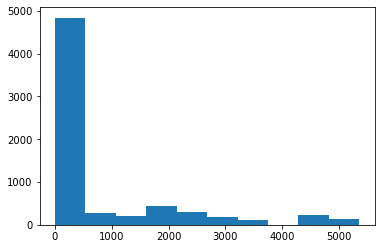

In [27]:
plt.hist(rural_streets_pop_2045['Pop_den'])

(array([6860.,  796.,   83.,    0.,   63.,   14.,   40.,    0.,   17.,
           7.]),
 array([    0. ,  8483.1, 16966.2, 25449.3, 33932.4, 42415.5, 50898.6,
        59381.7, 67864.8, 76347.9, 84831. ]),
 <BarContainer object of 10 artists>)

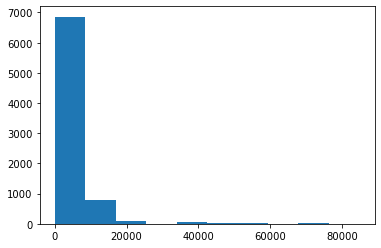

In [28]:
plt.hist(urban_streets_pop_2045['Pop_den'])

In [29]:
print(df_rural_2045.shape)
print(rural_streets_pop_2045.shape)
print(df_urban_2045.shape)
print(urban_streets_pop_2045.shape)
# There are segments that have duplicate Pop_den_20XX records in streets_pop
# Some road segments belongs two blocks, some other road segments are on the boundary of two blocks,
# Thus, these road segments have more than one row of Pop_den_20XX records

(5684, 61)
(6737, 65)
(6390, 61)
(7880, 65)


In [30]:
rural_streets_pop_2045 = drop_dup_seg(rural_streets_pop_2045,Pref_TAZPop_2045,df_rural_test)
urban_streets_pop_2045 = drop_dup_seg(urban_streets_pop_2045,Pref_TAZPop_2045,df_urban_test)

All the segments have only one record
All the segments have only one record


In [31]:
print(df_rural_2045.shape)
print(rural_streets_pop_2045.shape)
print(df_urban_2045.shape)
print(urban_streets_pop_2045.shape)

(5684, 61)
(5670, 65)
(6390, 61)
(6390, 65)


# 4C.5 Rearrange columns
<a id='rearrange-columns'></a>
[[back to top](#sections)]

In [32]:
rural_2045 = rural_streets_pop_2045[df_rural_test.columns]
rural_2045['Year'] = 2045

urban_2045 = urban_streets_pop_2045[df_urban_test.columns]
urban_2045['Year'] = 2045

In [33]:
rural_2045.head()

segment_id overlap   st_length  curve_ratio one_way  \
6            6       P  407.218450     1.000024       0   
9            9       P  205.961843     1.000024       0   
11          11       P  290.782018     0.997698       0   
12          12       P  127.399213     0.986779       0   
20          20       P  131.137706     1.000024       0   

    bicycle_facility_width bicycle_path_category  bicycle_buffer_width  \
6                      0.0                  None                   0.0   
9                      0.0                  None                   0.0   
11                     0.0                  None                   0.0   
12                     0.0                  None                   0.0   
20                     0.0                  None                   0.0   

   bicycle_buffer_type bicycle_path_type  ...   MPO   MUNI_NAME  NHS TRK_RT  \
6                 None              None  ...  0000     Rantoul    0      0   
9                 None              None  ...  0000     Rantoul    0      0   
11                None              None  ...  0000  Thomasboro    0      0   
12                None              None  ...  0000     Rantoul    0      0   
20                None              None  ...  0000     Rantoul    0      0   

      AADT   HCV Pop_den       PC  \
6   1450.0  94.0  4429.0  Unknown   
9    150.0  37.0   313.0  Unknown   
11   676.0  37.0  1899.0  Unknown   
12   676.0  37.0    28.0  Unknown   
20   676.0  37.0  5071.0  Unknown   

                                             geometry  Year  
6   LINESTRING (1034468.440 1328466.901, 1034875.6...  2045  
9   LINESTRING (1032880.760 1328642.290, 1032883.3...  2045  
11  LINESTRING (1023340.700 1301579.500, 1023357.2...  2045  
12  LINESTRING (1030162.808 1316475.884, 1030163.6...  2045  
20  LINESTRING (1036744.612 1327880.536, 1036745.3...  2045  

[5 rows x 62 columns]

In [34]:
rural_2045.columns

Index(['segment_id', 'overlap', 'st_length', 'curve_ratio', 'one_way',
       'bicycle_facility_width', 'bicycle_path_category',
       'bicycle_buffer_width', 'bicycle_buffer_type', 'bicycle_path_type',
       'bicycle_approach_alignment', 'bus_trips_total', 'crossing_aadt',
       'crossing_functional_classification', 'crossing_speed',
       'functional_classification', 'intersection_control_type',
       'lane_configuration', 'max_lanes_crossed', 'parking_lane_width',
       'marked_center_line', 'posted_speed', 'railroad_crossing_type',
       'right_turn_length', 'road_sign_type', 'sidewalk_buffer_width',
       'sidewalk_condition_score', 'sidewalk_width', 'sidewalk_buffer_type',
       'total_lanes', 'in_urbanized_area', 'volume_capacity',
       'overall_landuse', 'ACC_CNTL', 'I_SHD1_TYP', 'I_SHD1_WTH', 'I_SHD2_TYP',
       'I_SHD2_WTH', 'LN_WTH', 'LNS', 'MED_TYP', 'MED_WTH', 'SURF_TYP',
       'SURF_WTH', 'O_SHD1_TYP', 'O_SHD1_WTH', 'O_SHD2_TYP', 'O_SHD2_WTH',
       'OP_1_2_

# 4C.6 Save 2045 data
<a id='save-2045-data'></a>
[[back to top](#sections)]

In [35]:
with open('../data/processed/rural_2045.pkl', 'wb') as f:
    pickle.dump(rural_2045, f)
    
with open('../data/processed/urban_2045.pkl', 'wb') as f:
    pickle.dump(urban_2045, f)

# 4C.7 Mapping
<a id='mapping'></a>
[[back to top](#sections)]

In [36]:
def geo_segmentid(streets):
    """
    This function project PCD roadway segments to epsg:3435
    """
    SegmentID=streets[['segment_id','st_astext']]
    SegmentID.loc[:,'geom'] = SegmentID.loc[:,'st_astext'].apply(wkt.loads)
    geo_SegmentID = gpd.GeoDataFrame(
        SegmentID,
        geometry=SegmentID.geom,
        crs = {'init': 'epsg:3435'})

    return geo_SegmentID

# Project PCD roadway segments to epsg:3435
geo_SubsegmentID = geo_segmentid(streets)

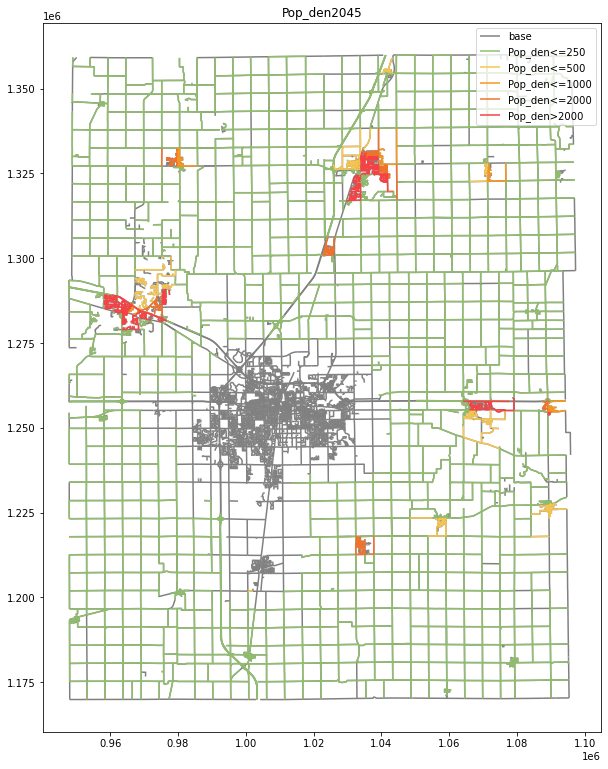

In [37]:
plt_Pop_Year(2045,rural_2045,geo_SegmentID)

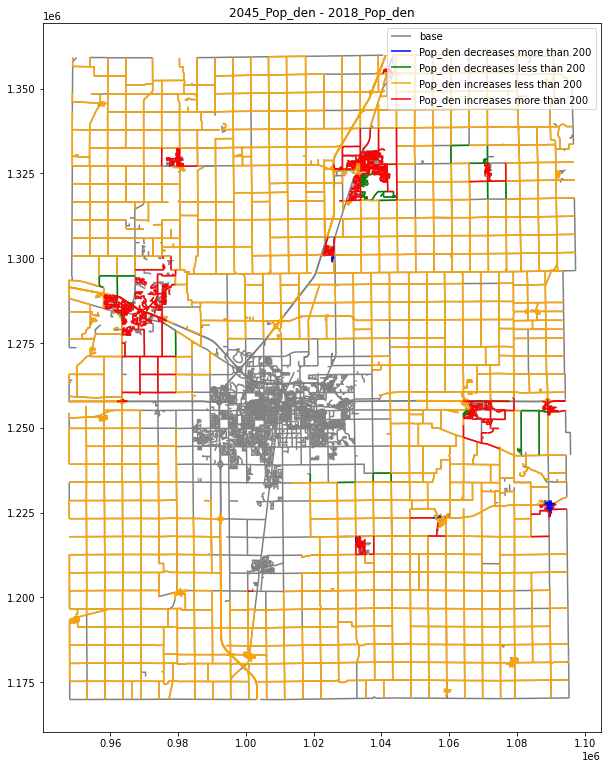

In [38]:
plt_Pop_Year_diff(2018,df_rural_test,2045,rural_2045,geo_SegmentID)

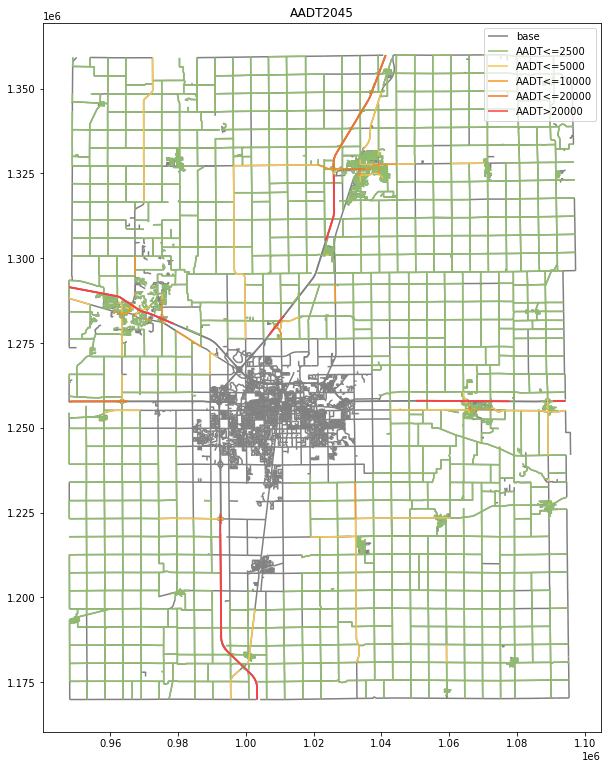

In [39]:
plt_AADT_Year(2045,rural_2045,geo_SegmentID)

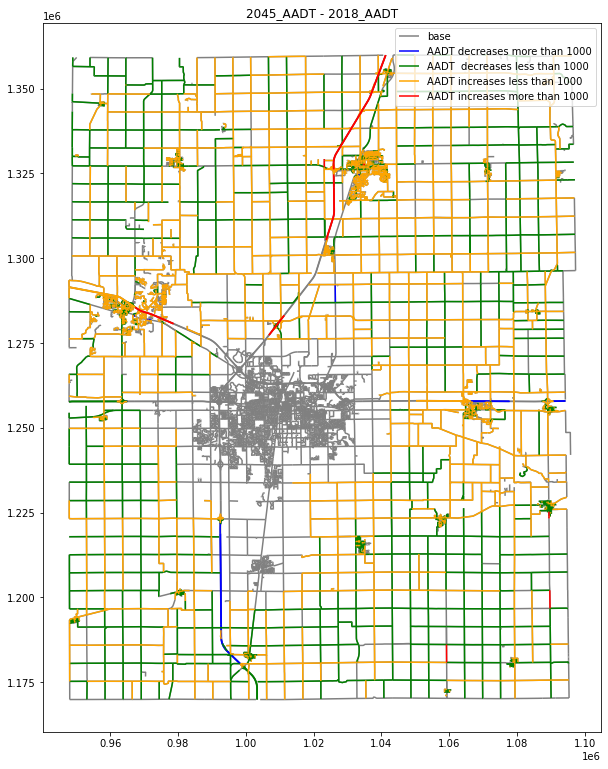

In [40]:
plt_AADT_Year_diff(2018,df_rural_test,2045,rural_2045,geo_SegmentID)

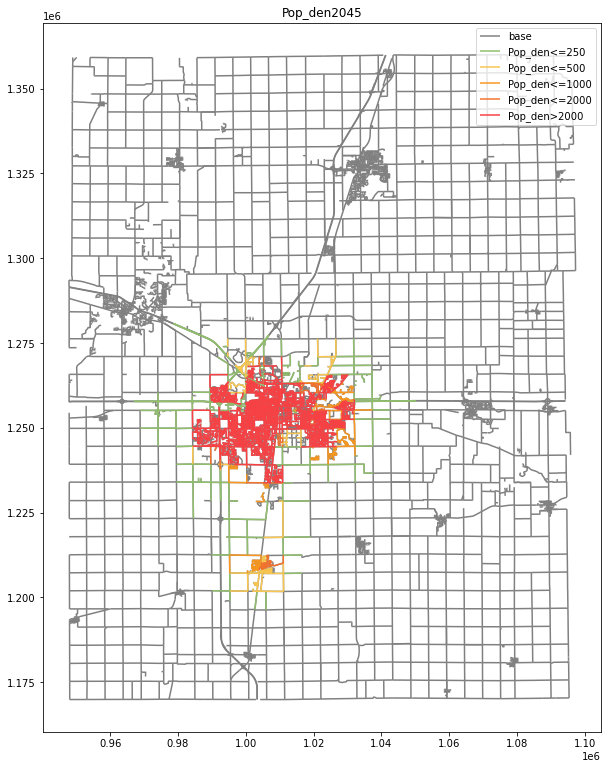

In [41]:
plt_Pop_Year(2045,urban_2045,geo_SegmentID)

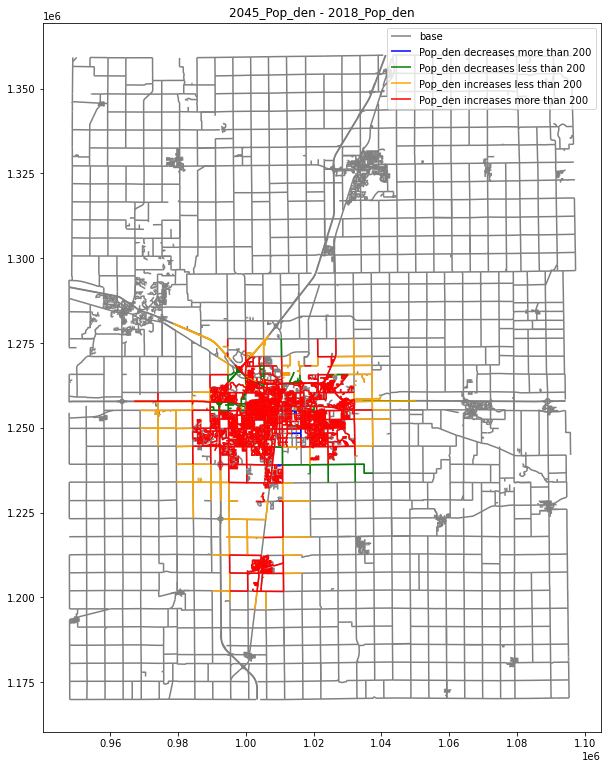

In [42]:
plt_Pop_Year_diff(2018,df_urban_test,2045,urban_2045,geo_SegmentID)

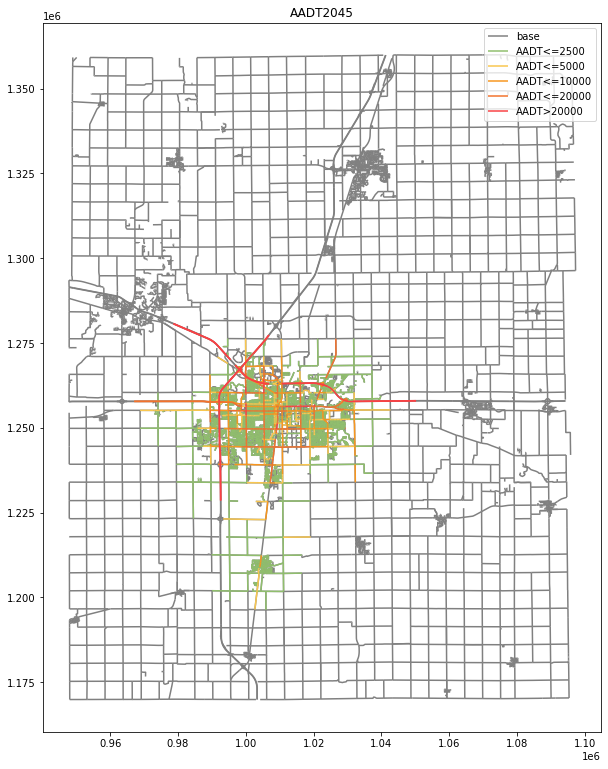

In [43]:
plt_AADT_Year(2045,urban_2045,geo_SegmentID)

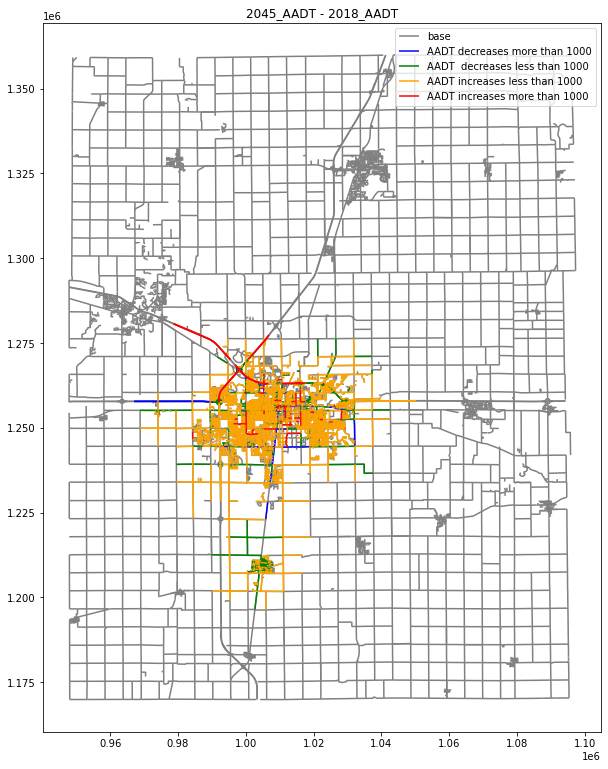

In [44]:
plt_AADT_Year_diff(2018,df_urban_test,2045,urban_2045,geo_SegmentID)